<a href="https://colab.research.google.com/github/RonnyGuevara/Digital-image-processing/blob/main/TP6/Pr%C3%A1ctica_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 6:  Convolución

##Presentado por: Ronny Guevara

## Objetivo General
Descomponer una imagen en sus componentes seno y coseno aplicando la transformada de Fourier 
## Objetivos Específicos
*   Representar la imagen en el dominio de frecuencia mediante la transformada de Fourier
*   Reconstruir una imagen mediante la transformada inversa de Fourier
*   Visualización de resultados en una interfaz amigable con el usuario

## Descripción del práctico:
Las actividades propuestas son:

*   Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
*   Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
*   Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4


In [1]:
#Librerías a utilizar
import cv2
from PIL import Image, ImageFilter
import tempfile
import imageio as io
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import time
from google.colab import files
import math

In [2]:
#Función que permite leer una imagen sin limitación de UNIT8
def get_image(dir):
  image = io.imread(dir)
  image = image.astype(np.int)
  return image

#Función que permite plotear la imagen
def plot2_image(image,Imagen, cmap=None):
  plt.figure(figsize=(100,100)) 
  plt.figure()
  plt.title(Imagen)
  plt.imshow(image,cmap=cmap)
  plt.grid(False)
  plt.show()

#Copia de la imagen Original
def image_copy(image):
  work_image=np.copy(image)
  return work_image 

#Información de la imagen
def image_info(image):
  print('This image is', image.dtype)
  print('with dimensions', image.shape)

#Normalización de las imágenes
def image_norm(image):
  norm=image.astype(np.float64)/255
  return norm

#Conversión RGB2YIQ
def image_RGB2YIQ(image):
  matrixYIQ=np.array([[0.299,0.587,0.144],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
  YIQ=np.dot(image,matrixYIQ)
  y = YIQ[:,:,0]
  i = YIQ[:,:,1]
  q = YIQ[:,:,2]
  y = np.clip(y, 0 ,1)
  q = np.clip(q,-0.5957 , 0.5957 )
  i = np.clip(i, -0.5226 , 0.5226) 
  return y, i, q

#Construcción de la imagen a partir de las componentes YIQ
def yiq_to_image(y,i,q):
  Shape = y.shape
  im_out = np.zeros((Shape[0], Shape[1], 3))
  im_out[:,:,0] = y
  im_out[:,:,1] = i
  im_out[:,:,2] = q
  return im_out.astype(np.float64)
  
#Conversión YIQ2RGB
def image_YIQ2RGB(image):
  matrixRGB=np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
  RGB=np.dot(image,matrixRGB)
  RGB=RGB.clip(0,1)*255
  RGB=RGB.astype(np.uint8)
  return RGB

In [3]:
#Función que permite obtener la transformada de Fourier
def fft_imagen(y):
  fc = np.fft.fftshift(np.fft.fft2(y)) #numpy
  mag = np.abs(fc)
  mag = np.log(mag + 1)
  phase = np.angle(fc) 
  return mag, phase

#Función que permite obtener la transformada inversa de Fourier
def ifft_imagen(mag, phase):
  image_final=(np.power(np.e, mag) - 1) * (np.cos(phase) + np.sin(phase) * 1j)
  image_final=np.abs(fftpack.ifft2(fftpack.ifftshift(image_final)))
  image_final=np.clip(image_final,0 ,255)
  return image_final

#Función padding
def padding (image1, dato):
  f1, c1, _ = image1.shape
  dato = dato - 1
  dato2 = (dato * 2/3)
  dato3 = math.trunc(dato2)
  fmax = f1 + dato
  cmax = c1 + dato
  im1_new = np.zeros ((fmax, cmax,3), dtype='float')
  for i in range(f1):
    for j in range(c1): 
      im1_new[i+dato3,j+dato3,:] = image1[i,j,:]
  return im1_new, fmax, cmax, dato3, f1, c1

#Función filtro pasa bajos
def low_pass_filter(y, kernel):
  im = y.copy() / y.max()
  im_h = im.shape[0] 
  im_w = im.shape[1]
  k_h = kernel.shape[0]
  k_w = kernel.shape[1]
  pad_h = (k_h - 1) // 2
  pad_w = (k_w - 1) // 2
  out = np.zeros(im.shape) 
  for row in range(im_h):
    for col in range(im_w):
      range_w = range((col - pad_w), (col + pad_w + 1))
      range_h = range((row - pad_h), (row + pad_h + 1))
      idx_w = np.clip(np.array(range_w),0,im_w-1)
      idx_h = np.clip(np.array(range_h),0,im_h-1)
      sub_im = im[np.ix_(idx_h,idx_w)]
      out[row,col] = np.multiply(sub_im,kernel).sum()
  return out

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<Figure size 7200x7200 with 0 Axes>

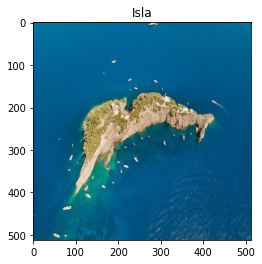

In [5]:
#@title Selecciona primera imagen { run: "auto" }
Loro='/content/drive/MyDrive/Colab Notebooks/loro.jpg'
Ciudad='/content/drive/MyDrive/Colab Notebooks/Ciudad.jpg'
SistemaSolar='/content/drive/MyDrive/Colab Notebooks/SisSolar.jpg'
Coliseo='/content/drive/MyDrive/Colab Notebooks/Coliseo.jpg'
Isla='/content/drive/MyDrive/Colab Notebooks/Isla.jpg'
Selva='/content/drive/MyDrive/Colab Notebooks/Selva.jpg'
Imagen = 'Isla' #@param ["Loro", "Ciudad", "SistemaSolar", "Coliseo", "Isla", "Selva"]

if Imagen == 'Loro':
  image = get_image(Loro)
  plot2_image(image, 'Loro')
elif Imagen == 'Ciudad':
  image = get_image(Ciudad)
  plot2_image(image, 'Ciudad')
elif Imagen == 'SistemaSolar':
  image = get_image(SistemaSolar)
  plot2_image(image, 'SistemaSolar')
elif Imagen == 'Isla':
  image = get_image(Isla)
  plot2_image(image, 'Isla')
elif Imagen == 'Selva':
  image = get_image(Selva)
  plot2_image(image, 'Selva')
elif Imagen == 'Coliseo':
  image = get_image(Coliseo)
  plot2_image(image, 'Coliseo')

In [6]:
#Proceso de copia de la imagen y visualización de información
work_image=image_copy(image)
image_info(work_image)

This image is int64
with dimensions (512, 512, 3)


<Figure size 7200x7200 with 0 Axes>

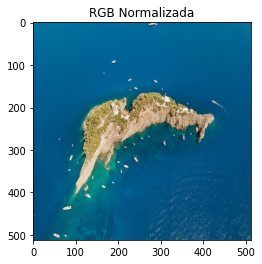

In [7]:
#Normalización de la imagen y conversión del espacio RGB a YIQ
work_image=image_norm(work_image)
plot2_image(work_image,'RGB Normalizada',cmap=None)

<Figure size 7200x7200 with 0 Axes>

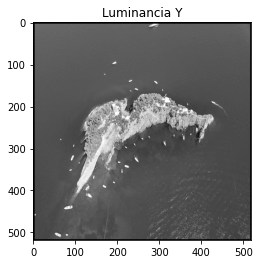

In [8]:
ima, fmax, cmax, dato, f1, c1 = padding (work_image, 7)
y, i, q = image_RGB2YIQ(ima)
plot2_image(y,'Luminancia Y',cmap='gray')

In [9]:
#Kernels para filtro pasa bajo llano
kernel3=np.array([[1/9, 1/9, 1/9],[1/9, 1/9, 1/9],[1/9, 1/9, 1/9]])
kernel5=np.array([[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04]])
kernel7=np.array([[0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816],[0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816]])

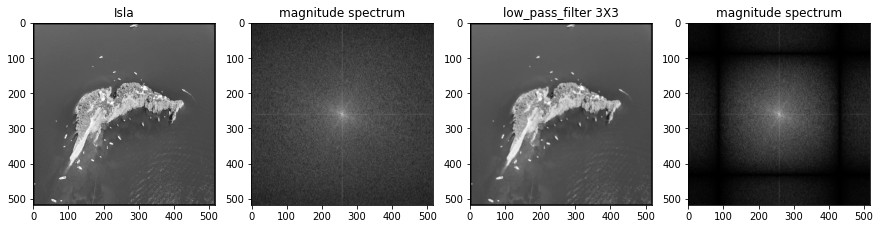

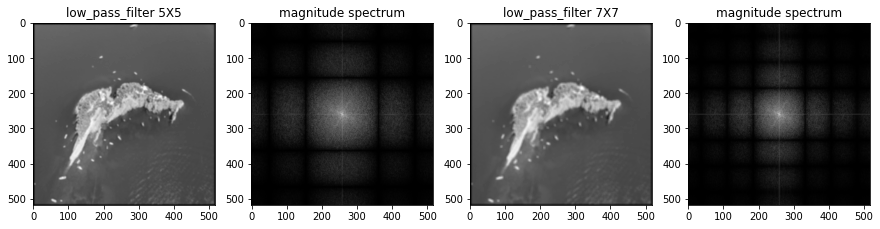

In [10]:
#Filtro Pasa Bajos llano
mag, phase = fft_imagen (y)
new_imagen1=low_pass_filter(y,kernel3)
new_imagen2=low_pass_filter(y,kernel5)
new_imagen3=low_pass_filter(y,kernel7)
mag1, phase1 = fft_imagen (new_imagen1)
mag2, phase2 = fft_imagen (new_imagen2)
mag3, phase3 = fft_imagen (new_imagen3)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagen1, 'gray')
axes[2].set_title('low_pass_filter 3X3')
axes[3].imshow(mag1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_imagen2,'gray')
axes[0].set_title('low_pass_filter 5X5')
axes[1].imshow(mag2, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagen3,'gray')
axes[2].set_title('low_pass_filter 7X7')
axes[3].imshow(mag3, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()


In [11]:
#Kernels para filtro pasa bajo Bartlett
kernel3b=np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]])
kernel5b=np.array([[1/81, 2/81, 3/81, 2/81, 1/81],[2/81, 4/81, 6/81, 4/81, 2/81], [3/81, 6/81, 9/81, 6/81, 3/81],[2/81, 4/81, 6/81, 4/81, 2/81], [1/81, 2/81, 3/81, 2/81, 1/81] ])
kernel7b=np.array([[1/256, 2/256, 3/256, 4/256, 3/256, 2/256, 1/256], [2/256, 4/256, 6/256, 8/256, 6/256, 4/256, 2/256], [3/256, 6/256, 9/256, 12/256, 9/256, 6/256, 3/256], [4/256, 8/256, 12/256, 16/256, 12/256, 8/256, 4/256], [3/256, 6/256, 9/256, 12/256, 9/256, 6/256, 3/256], [2/256, 4/256, 6/256, 8/256, 6/256, 4/256, 2/256], [1/256, 2/256, 3/256, 4/256, 3/256, 2/256, 1/256]])

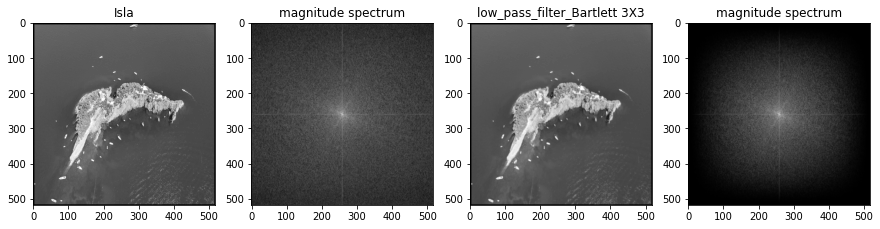

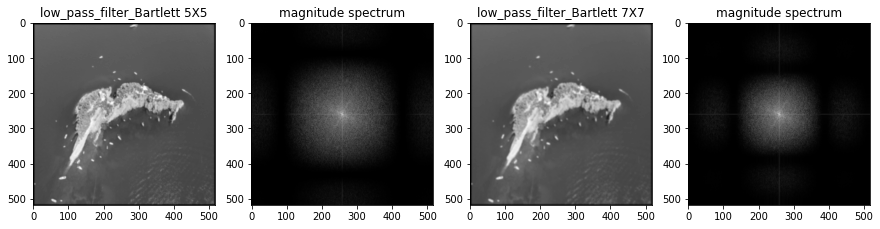

In [12]:
#Filtro Pasa Bajos Bartlett
mag, phase = fft_imagen (y)
new_imagenb1=low_pass_filter(y,kernel3b)
new_imagenb2=low_pass_filter(y,kernel5b)
new_imagenb3=low_pass_filter(y,kernel7b)
magb1, phaseb1 = fft_imagen (new_imagenb1)
magb2, phaseb2 = fft_imagen (new_imagenb2)
magb3, phaseb3 = fft_imagen (new_imagenb3)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagenb1, 'gray')
axes[2].set_title('low_pass_filter_Bartlett 3X3')
axes[3].imshow(magb1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_imagenb2,'gray')
axes[0].set_title('low_pass_filter_Bartlett 5X5')
axes[1].imshow(magb2, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagenb3,'gray')
axes[2].set_title('low_pass_filter_Bartlett 7X7')
axes[3].imshow(magb3, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

In [13]:
#Kernels para filtro pasa bajo Gaussiano
kernel3g=np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]])
kernel5g=np.array([[1/256, 4/256, 6/256, 4/256, 1/256],[4/256, 16/256, 24/256, 16/256, 4/256], [6/256, 24/256, 36/256, 24/256, 6/256], [4/256, 16/256, 24/256, 16/256, 4/256],[1/256, 4/256, 6/256, 4/256, 1/256]])
kernel7g=np.array([[1/3880, 6/3880, 15/3880, 20/3880, 15/3880, 6/3880, 1/3880],[6/3880, 36/3880, 90/3880, 120/3880, 90/3880, 36/3880, 16/3880], [15/3880, 90/3880, 225/3880, 300/3880, 225/3880, 90/3880, 15/3880],
                   [20/3880, 120/3880, 300/3880, 400/3880, 300/3880, 120/3880, 20/3880], [15/3880, 90/3880, 225/3880, 300/3880, 225/3880, 90/3880, 15/3880], [6/3880, 36/3880, 90/3880, 120/3880, 90/3880, 36/3880, 6/3880], [1/3880, 6/3880, 15/3880, 20/3880, 15/3880, 6/3880, 1/3880]])

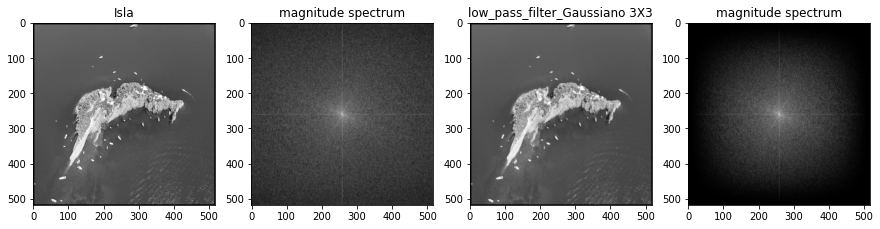

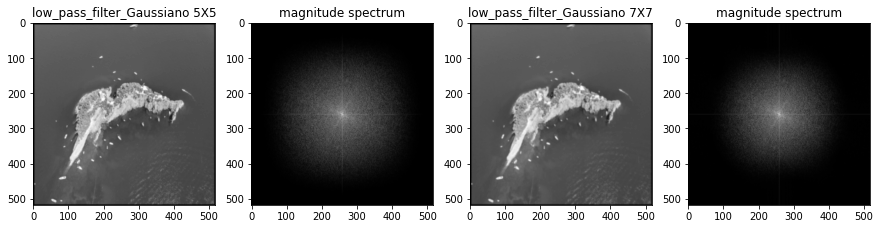

In [14]:
#Filtro Pasa Bajos Gaussiano
mag, phase = fft_imagen (y)
new_imageng1=low_pass_filter(y,kernel3g)
new_imageng2=low_pass_filter(y,kernel5g)
new_imageng3=low_pass_filter(y,kernel7g)
magg1, phaseb1 = fft_imagen (new_imageng1)
magg2, phaseb2 = fft_imagen (new_imageng2)
magg3, phaseb3 = fft_imagen (new_imageng3)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imageng1, 'gray')
axes[2].set_title('low_pass_filter_Gaussiano 3X3')
axes[3].imshow(magg1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_imageng2,'gray')
axes[0].set_title('low_pass_filter_Gaussiano 5X5')
axes[1].imshow(magg2, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imageng3,'gray')
axes[2].set_title('low_pass_filter_Gaussiano 7X7')
axes[3].imshow(magg3, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

In [20]:
#Kernels para filtro detector de bordes Laplaciano
kernelv3=np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]])
kernelv8=np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])

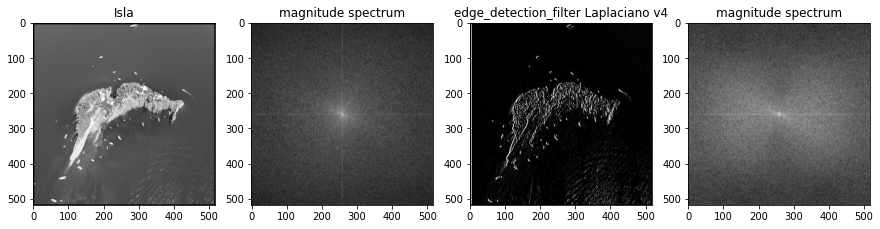

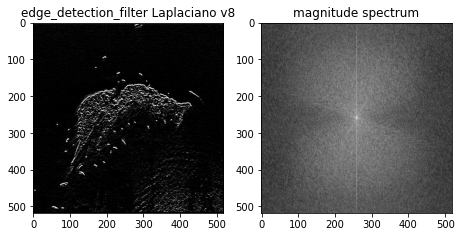

In [36]:
#Filtro Detector de bordes Laplaciano
mag, phase = fft_imagen (y)
new_imagelv4=low_pass_filter(y,kernelv3)
new_imagelv4=np.clip(new_imagelv4,0,1)
new_imagelv8=low_pass_filter(y,kernelv8)
new_imagelv8=np.clip(new_imagelv8,0,1)
magl1, phasel1 = fft_imagen (new_imagelv4)
magl2, phasel2 = fft_imagen (new_imagelv8)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagelv4, 'gray')
axes[2].set_title('edge_detection_filter Laplaciano v4')
axes[3].imshow(magl1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7.5,7.5)
axes[0].imshow(new_imagelv8,'gray')
axes[0].set_title('edge_detection_filter Laplaciano v8')
axes[1].imshow(magl2, 'gray')
axes[1].set_title('magnitude spectrum')
plt.show()

In [34]:
#Kernels para filtros direccionales
kernels1=np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernels2=np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])
kernels3=np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
kernels4=np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])

kernels5=np.array([[-1, -2, 0],[-1, 0, 1],[0, 2, 1]])
kernels6=np.array([[0, -2, -1],[1, 0, -1],[1, 2, 0]])
kernels7=np.array([[1, 1, 0],[2, 0, -2],[0, -1, -1]])
kernels8=np.array([[0, 1, 1],[-2, 0, 2],[-1, -1, 0]])

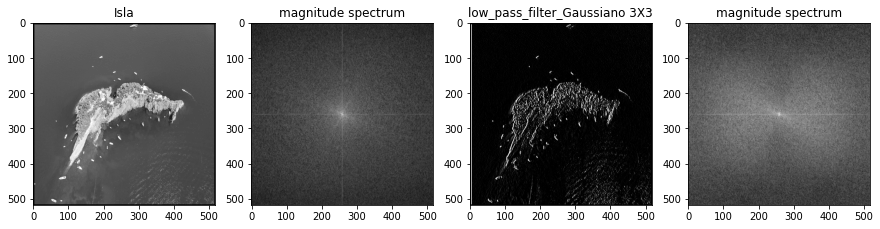

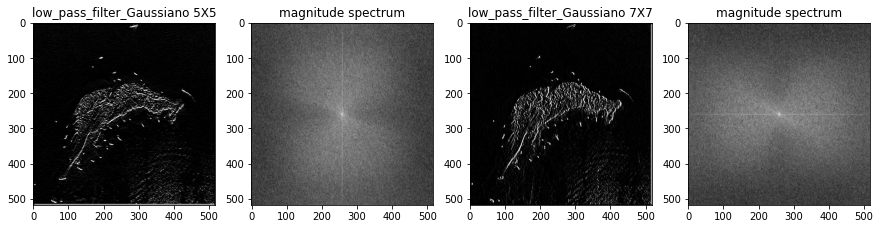

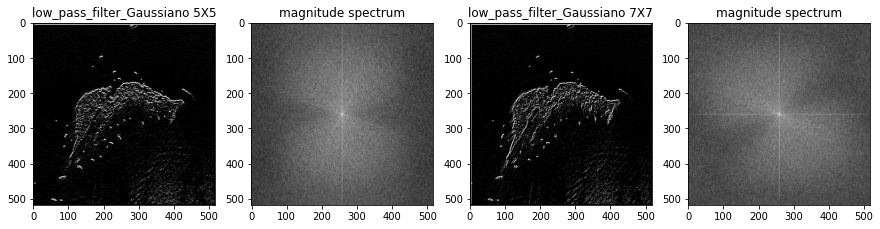

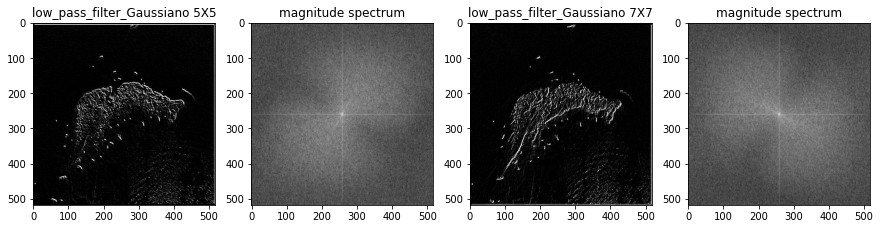

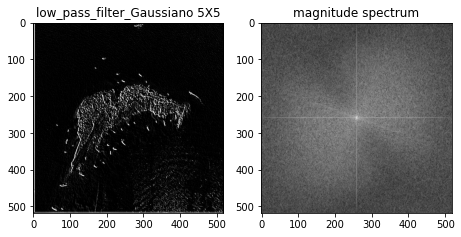

In [37]:
#Filtro Direccional
mag, phase = fft_imagen (y)
new_images1=low_pass_filter(y,kernels1)
new_images1=np.clip(new_images1,0,1)
new_images2=low_pass_filter(y,kernels2)
new_images2=np.clip(new_images2,0,1)
new_images3=low_pass_filter(y,kernels3)
new_images3=np.clip(new_images3,0,1)
new_images4=low_pass_filter(y,kernels4)
new_images4=np.clip(new_images4,0,1)

new_images5=low_pass_filter(y,kernels5)
new_images5=np.clip(new_images5,0,1)
new_images6=low_pass_filter(y,kernels6)
new_images6=np.clip(new_images6,0,1)
new_images7=low_pass_filter(y,kernels7)
new_images7=np.clip(new_images7,0,1)
new_images8=low_pass_filter(y,kernels8)
new_images8=np.clip(new_images8,0,1)

mags1, phases1 = fft_imagen (new_images1)
mags2, phases2 = fft_imagen (new_images2)
mags3, phases3 = fft_imagen (new_images3)
mags4, phases4 = fft_imagen (new_images4)

mags5, phases5 = fft_imagen (new_images5)
mags6, phases6 = fft_imagen (new_images6)
mags7, phases7 = fft_imagen (new_images7)
mags8, phases8 = fft_imagen (new_images8)

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_images1, 'gray')
axes[2].set_title('low_pass_filter_Gaussiano 3X3')
axes[3].imshow(mags1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_images2,'gray')
axes[0].set_title('low_pass_filter_Gaussiano 5X5')
axes[1].imshow(mags2, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_images3,'gray')
axes[2].set_title('low_pass_filter_Gaussiano 7X7')
axes[3].imshow(mags3, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_images4,'gray')
axes[0].set_title('low_pass_filter_Gaussiano 5X5')
axes[1].imshow(mags4, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_images5,'gray')
axes[2].set_title('low_pass_filter_Gaussiano 7X7')
axes[3].imshow(mags5, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_images6,'gray')
axes[0].set_title('low_pass_filter_Gaussiano 5X5')
axes[1].imshow(mags6, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_images7,'gray')
axes[2].set_title('low_pass_filter_Gaussiano 7X7')
axes[3].imshow(mags7, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7.5,7.5)
axes[0].imshow(new_images8,'gray')
axes[0].set_title('low_pass_filter_Gaussiano 5X5')
axes[1].imshow(mags8, 'gray')
axes[1].set_title('magnitude spectrum')
plt.show()

<Figure size 7200x7200 with 0 Axes>

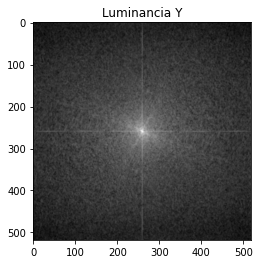

<Figure size 7200x7200 with 0 Axes>

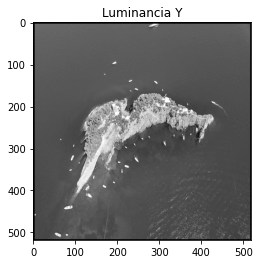

In [15]:
im = mag.copy() / mag.max()
im_h = im.shape[0] 
im_w = im.shape[1]
k_h = kernel3.shape[0]
k_w = kernel3.shape[1]
pad_h = (k_h - 1) // 2
pad_w = (k_w - 1) // 2
out = np.zeros(im.shape)
for row in range(im_h):   
    for col in range(im_w): 
        for range_w in range((col - pad_w),(col + pad_w + 1)):    
            for range_h in range((row - pad_h), (row + pad_h + 1)):
              range_w = range((col - pad_w), (col + pad_w + 1))
              range_h = range((row - pad_h), (row + pad_h + 1))
              idx_w = np.clip(np.array(range_w),0,im_w-1)
              idx_h = np.clip(np.array(range_h),0,im_h-1)
              sub_im = im[np.ix_(idx_h,idx_w)]
              out[row,col] = np.multiply(sub_im,kernel3).sum()
plot2_image(out,'Luminancia Y', cmap='gray')
plot2_image(y,'Luminancia Y', cmap='gray')


In [16]:
mag, phase = fft_imagen(y)
mag2, phase2 = fft_imagen(kernel3)

In [17]:
# first a conservative filter for grayscale images will be defined.
def conservative_smoothing_gray(data, filter_size):
  temp = [] 
  indexer = filter_size // 2 
  new_image = data.copy() 
  nrow, ncol = data.shape
  for i in range(nrow):   
      for j in range(ncol):   
          for k in range(i-indexer, i+indexer+1):    
              for m in range(j-indexer, j+indexer+1):
                 if (k > -1) and (k < nrow):
                  if (m > -1) and (m < ncol):
                    temp.append(data[k,m])
  temp.remove(data[i,j])
  max_value = max(temp)
  min_value = min(temp)
  if data[i,j] > max_value:
    new_image[i,j] = max_value
  elif data[i,j] < min_value:
    new_image[i,j] = min_value
  temp =[]
  return new_image.copy()

<Figure size 7200x7200 with 0 Axes>

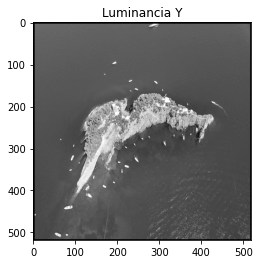

KeyboardInterrupt: ignored

In [18]:
plot2_image(y,'Luminancia Y',cmap='gray')
new_image=conservative_smoothing_gray(mag, 25)
new_image=ifft_imagen(out, mag)
new_image=yiq_to_image(new_image,i,q)
new_image=image_YIQ2RGB(new_image)
plot2_image(new_image,'Luminancia Y')
plot2_image(new_image,'Luminancia Y',cmap='gray')